In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_all = pd.read_csv('data/seg_scores_per_image_all_bpd_2021-08-03.csv')
df_patient = df_all.loc[df_all['image_id'] == 0]

df_regression_lufu = pd.read_csv('data/regression_lufu_2021-08-03.csv')

## Figure 1 - MRI-based Neonatal Lung Volume Analysis Pipeline.

In [4]:
# modify to site 1 and site 2
di = {'Gießen': "Site 2", "Großhadern": "Site 1"}
df_patient.replace({"cohort": di}, inplace=True)

array_models_and_manual = [
    'p1_vs_rest_patient',
    'model_p1_vs_rest_patient',
    'p2_vs_rest_patient',
    'model_p2_vs_rest_patient',
    'p3_vs_rest_patient',
    'model_p3_vs_rest_patient',
    'maj_on_maj_patient']

# modify dataframe to plot in sns
df_patient_for_sns = pd.melt(df_patient, 
                             id_vars=['patient', 'image_quality', 'bpd_severity', 'cohort'], 
                             value_vars=array_models_and_manual)

df_patient_for_sns['dice_coeff'] = df_patient_for_sns['value'].map(lambda x: 1 - x)

def cohort_rater(row):
    if row['cohort'] == 'Site 1':
        if row['variable'] == 'p1_vs_rest_patient' or row['variable'] == 'model_p1_vs_rest_patient':
            return 'Site 1 (P1,MP1)'
        elif row['variable'] == 'p2_vs_rest_patient' or row['variable'] == 'model_p2_vs_rest_patient':
            return 'Site 1 (P2,MP2)'
        elif row['variable'] == 'p3_vs_rest_patient' or row['variable'] == 'model_p3_vs_rest_patient':
            return 'Site 1 (P3,MP3)'
        elif row['variable'] == 'maj_on_maj_patient':
            return 'Site 1 (MV)'

    elif row['cohort'] == 'Site 2':
        if row['variable'] == 'p1_vs_rest_patient' or row['variable'] == 'model_p1_vs_rest_patient':
            return 'Site 2 (P1,MP1)'
        elif row['variable'] == 'p2_vs_rest_patient' or row['variable'] == 'model_p2_vs_rest_patient':
            return 'Site 2 (P2,MP2)'
        elif row['variable'] == 'p3_vs_rest_patient' or row['variable'] == 'model_p3_vs_rest_patient':
            return 'Site 2 (P3,MP3)'
        elif row['variable'] == 'maj_on_maj_patient':
            return 'Site 2 (MV)'

        
new_column = df_patient_for_sns.apply(lambda row: cohort_rater(row), axis=1)
df_patient_for_sns['expert-type'] = new_column


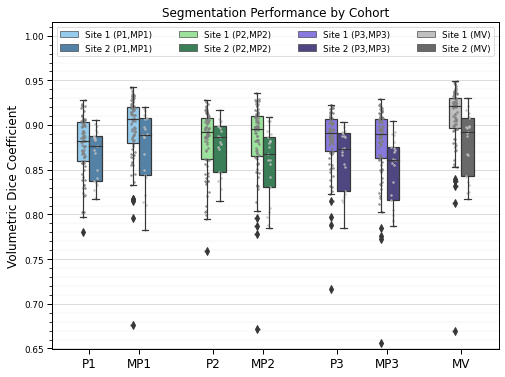

In [5]:
sns.set_context("paper")
font_s = 12
f = plt.figure(figsize=(8, 6))
gs = f.add_gridspec(1, 1)


ax = f.add_subplot(gs[0, 0])
sns.boxplot(x='variable', y='dice_coeff', hue="expert-type",
            data=df_patient_for_sns, 
            palette=[
                "lightskyblue", "steelblue",
                "lightgreen", "seagreen",
                "mediumslateblue", "darkslateblue",
                "silver", "dimgrey",
                    ],
            width=2,
            whis=1.5,
            hue_order=[
                'Site 1 (P1,MP1)','Site 2 (P1,MP1)',
                'Site 1 (P2,MP2)','Site 2 (P2,MP2)',
                'Site 1 (P3,MP3)','Site 2 (P3,MP3)',
                'Site 1 (MV)', 'Site 2 (MV)',
            ]
           )

x_ticks_box_plots = [-0.875, -0.625, 
                     0.125, 0.375, 
                     1.62, 1.875, 
                     2.625, 2.875, 
                     4.125, 4.375,
                     5.125,5.375,
                     6.625, 6.875]

sites = ['Site 1', 'Site 2']
colors = ['gray', 'silver']
counter = 0
for i in range(len(array_models_and_manual)):
    df_temp = df_patient_for_sns.loc[df_patient_for_sns['variable'] == array_models_and_manual[i]]
    for j in range(len(sites)):
        df_temp_2 = df_temp.loc[df_temp['cohort'] == sites[j]]
        y=df_temp_2['dice_coeff']
        x=np.ones(len(y))*x_ticks_box_plots[counter] 
        x = x + (np.random.uniform(-1,1,len(y))*0.04)
        plt.scatter(x, y, c=colors[j],s=3, marker='o', alpha=0.75)
        counter+=1

ax.set_title('Segmentation Performance by Cohort', fontsize = font_s)
ax.set_xlabel('')
ax.set_ylabel('Volumetric Dice Coefficient', fontsize = font_s)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='k', alpha=0.2, linewidth=0.2)
ax.set_xticks([-0.75,0.25,1.75,2.75,4.25,5.25,6.75]) # <--- set the ticks first
ax.set_xticklabels(['P1', 'MP1','P2','MP2','P3','MP3','MV'],fontsize = font_s)
ax.legend(
    loc='upper left', ncol=4, mode='expand')
ax.set_xlim([-1.5, 7.5]) 
ax.set_ylim([0.65, 1.015]) 

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')

#plt.savefig('Model_Volume_Performance_Boxplot.pdf')
plt.show()

In [6]:
df_diff = df_patient[['p1_vs_rest_patient', 
            'p2_vs_rest_patient', 
            'p3_vs_rest_patient',
            'model_p1_vs_rest_patient',
            'model_p2_vs_rest_patient',
            'model_p3_vs_rest_patient'
           ]]
df_diff['model_p1_diff']=df_diff['model_p1_vs_rest_patient']-df_diff['p1_vs_rest_patient']
df_diff['model_p2_diff']=df_diff['model_p2_vs_rest_patient']-df_diff['p2_vs_rest_patient']
df_diff['model_p3_diff']=df_diff['model_p3_vs_rest_patient']-df_diff['p3_vs_rest_patient']

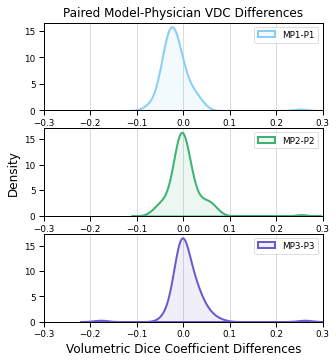

In [7]:
sns.set_context("paper")

font_s = 12

fig, axs = plt.subplots(3,1, figsize=(5,5.5))
#fig.tight_layout()

axs[0].set_xlim(-0.3, 0.3)
axs[1].set_xlim(-0.3, 0.3)
axs[2].set_xlim(-0.3, 0.3)

sns.kdeplot(df_diff['model_p1_diff'], ax=axs[0], alpha=0.1, linewidth = 2 , color='lightskyblue', label='MP1-P1',shade=True)
sns.kdeplot(df_diff['model_p2_diff'], ax=axs[1], alpha=0.1, linewidth = 2, color='mediumseagreen', label='MP2-P2', shade=True)
sns.kdeplot(df_diff['model_p3_diff'], ax=axs[2], alpha=0.1, linewidth = 2, color='slateblue', label='MP3-P3',shade=True)


axs[0].set_xlabel('', fontsize = font_s)
axs[1].set_xlabel('', fontsize = font_s)
axs[2].set_xlabel('Volumetric Dice Coefficient Differences', fontsize = font_s)


axs[0].set_ylabel('', fontsize = font_s)
axs[1].set_ylabel('Density', fontsize = font_s)
axs[2].set_ylabel('', fontsize = font_s)

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_title('Paired Model-Physician VDC Differences', fontsize = font_s)

axs[0].set_axisbelow(True)
axs[0].xaxis.grid(color='lightgray')
axs[1].set_axisbelow(True)
axs[1].xaxis.grid(color='lightgray')
axs[2].set_axisbelow(True)
axs[2].xaxis.grid(color='lightgray')

#plt.savefig('Paired-Differences.pdf')
plt.show()

Wilcoxon Test - Paired Differences

In [8]:
type_of_test='greater'
w, p = wilcoxon(df_diff['model_p1_diff'], alternative=type_of_test)
print('model_p1_diff', w,p)

w2, p2 = wilcoxon(df_diff['model_p2_diff'], alternative=type_of_test)
print('model_p2_diff', w2,p2)

w3, p3 = wilcoxon(df_diff['model_p3_diff'], alternative=type_of_test)
print('model_p3_diff', w3,p3)

model_p1_diff 864.0 0.9999999998450301
model_p2_diff 2785.0 0.6267406808752192
model_p3_diff 3399.0 0.056473410329970865


Average Paired Differences

In [9]:
mean_paired_diff=df_diff[['model_p1_diff', 'model_p2_diff', 'model_p3_diff']].mean()
print('mean')
print(mean_paired_diff)
std_paired_diff=df_diff[['model_p1_diff', 'model_p2_diff', 'model_p3_diff']].std()
print('std')
print(std_paired_diff)

mean
model_p1_diff   -0.016760
model_p2_diff    0.003035
model_p3_diff    0.006510
dtype: float64
std
model_p1_diff    0.035215
model_p2_diff    0.036540
model_p3_diff    0.037499
dtype: float64


## Figure 2 - Lung Segmentation and Lung Volume Analysis.

In [10]:
df_patient_for_sns_2 = pd.melt(df_patient, 
                             id_vars=['patient', 'image_quality', 'bpd_severity','cohort'], 
                             value_vars=[
                                 'p1_vs_rest_patient',
                                 'model_p1_vs_rest_patient',
                                 'p2_vs_rest_patient',
                                 'model_p2_vs_rest_patient',
                                 'p3_vs_rest_patient',
                                 'model_p3_vs_rest_patient',
                                 'maj_on_maj_patient'])

df_patient_for_sns_2['dice_coeff'] = df_patient_for_sns_2['value'].map(lambda x: 1 - x)

dict_bpd = {0.0: "No BPD", 1.0: "Mild", 2.0: "Moderate", 3.0: "Severe"}
df_patient_for_sns_2.replace({"bpd_severity": dict_bpd}, inplace=True)

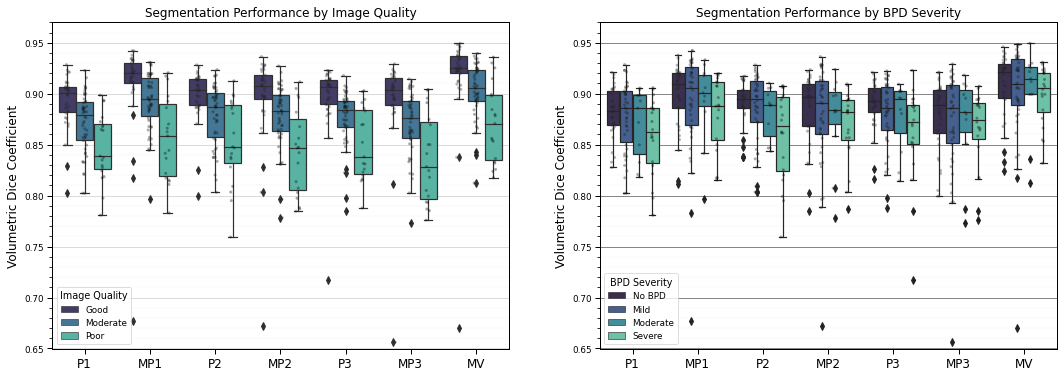

In [11]:
sns.set_context("paper")
font_s=12
f = plt.figure(figsize=(18, 6))
gs = f.add_gridspec(1, 2)


ax = f.add_subplot(gs[0, 0])
g = sns.boxplot(x='variable', y='dice_coeff', hue="image_quality",
            data=df_patient_for_sns_2, 
            palette="mako",
            #width=0.4,
           )

sns.stripplot(x='variable', y='dice_coeff', hue="image_quality",
              data=df_patient_for_sns_2,
              color='k',
              s=3, 
              # marker='.', 
              alpha=0.35,
              dodge=True)

ax.set_title('Segmentation Performance by Image Quality', fontsize = font_s)
ax.set_xlabel('')
ax.set_ylabel('Volumetric Dice Coefficient', fontsize = font_s)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='k', alpha=0.1, linewidth=0.2)
ax.set_xticks(range(7)) # <--- set the ticks first
ax.set_xticklabels(['P1','MP1','P2','MP2','P3','MP3', 'MV'],fontsize = font_s)
handles, _ = ax.get_legend_handles_labels()          # Get the artists.
ax.legend(handles, ["Good", "Moderate", "Poor"], title='Image Quality', loc="best") # Associate manually the artists to a label.


ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim([0.65, 0.97])


ax = f.add_subplot(gs[0, 1])
sns.boxplot(x='variable', y='dice_coeff', hue="bpd_severity",
            data=df_patient_for_sns_2, 
            palette="mako",
            # width=0.4,
            hue_order = ["No BPD", "Mild", "Moderate", "Severe"]
           )

sns.stripplot(x='variable', y='dice_coeff', hue="bpd_severity",
              data=df_patient_for_sns_2,
              color='k',
              alpha=0.35,
              size=3,
              # marker='.',
              dodge=True,
              hue_order = ["No BPD", "Mild", "Moderate", "Severe"]
           )

ax.set_title('Segmentation Performance by BPD Severity', fontsize = font_s)
ax.set_xlabel('')
ax.set_ylabel('Volumetric Dice Coefficient', fontsize = font_s)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='k', alpha=0.1, linewidth=0.2)
ax.set_xticks(range(7)) # <--- set the ticks first
ax.set_xticklabels(['P1','MP1','P2','MP2','P3','MP3', 'MV'],fontsize = font_s)

handles, _ = ax.get_legend_handles_labels()          # Get the artists.
ax.legend(handles, ["No BPD", "Mild", "Moderate", "Severe"], title='BPD Severity', loc="best") # Associate manually the artists to a label.

ax.set_axisbelow(True)
ax.yaxis.grid(color='dimgray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim([0.65, 0.97])

#plt.savefig('BPD_Severity.pdf')
plt.show()

Kruskal Wallis for differences in BPD Severity and Image Quality

In [12]:
# BPD Severity
name_models_dice = ['p1_vs_rest_patient','model_p1_vs_rest_patient',
 'p2_vs_rest_patient','model_p2_vs_rest_patient',
 'p3_vs_rest_patient','model_p3_vs_rest_patient',
 'maj_on_maj_patient']

bpd_severity_kw = {
    'model_name':[],
    'krustal_wallis_statistic':[],
    'p-value':[],
}

severities = np.arange(4)

for j in name_models_dice:
    list_groups = {}
    for i in severities:
        df_bpd_temp = df_patient.loc[df_all['bpd_severity'] == i]
        array_group = df_bpd_temp[j].apply(lambda x: 1 - x).to_numpy()
        str_json = 'bpd_' + str(i)
        list_groups[str_json] = array_group
    k, p = stats.kruskal(list_groups['bpd_0'], list_groups['bpd_1'], list_groups['bpd_2'], list_groups['bpd_3'])
    bpd_severity_kw['model_name'].append(j)
    bpd_severity_kw['krustal_wallis_statistic'].append(k)
    bpd_severity_kw['p-value'].append(p)

df_bpd_severity_kw = pd.DataFrame.from_dict(bpd_severity_kw)
print('Differences between bpd severities')
df_bpd_severity_kw

Differences between bpd severities


,model_name,krustal_wallis_statistic,p-value
0,p1_vs_rest_patient,6.002373,0.111495
1,model_p1_vs_rest_patient,3.644889,0.302451
2,p2_vs_rest_patient,6.904125,0.075017
3,model_p2_vs_rest_patient,4.679967,0.196788
4,p3_vs_rest_patient,6.913695,0.074700
5,model_p3_vs_rest_patient,2.093648,0.553199
6,maj_on_maj_patient,2.475087,0.479810


In [13]:
df_test = df_patient

name_models_dice = ['p1_vs_rest_patient','model_p1_vs_rest_patient',
 'p2_vs_rest_patient','model_p2_vs_rest_patient',
 'p3_vs_rest_patient','model_p3_vs_rest_patient',
 'maj_on_maj_patient']

img_quality_kw = {
    'model_name':[],
    'krustal_wallis_statistic':[],
    'p-value':[],
}

img_qualities = df_test['image_quality'].unique()

for j in name_models_dice:
    list_groups = {}
    for i in img_qualities:
        df_temp = df_test.loc[df_test['image_quality'] == i]
        array_group = df_temp[j].apply(lambda x: 1 - x).to_numpy()
        str_json = 'img_quality_' + str(i)
        list_groups[str_json] = array_group
    k, p = stats.kruskal(list_groups['img_quality_1'], 
                         list_groups['img_quality_2'], 
                         list_groups['img_quality_3'])
    img_quality_kw['model_name'].append(j)
    img_quality_kw['krustal_wallis_statistic'].append(k)
    img_quality_kw['p-value'].append(p)

df_img_quality_kw = pd.DataFrame.from_dict(img_quality_kw)
print('Differences between image qualities')
df_img_quality_kw

Differences between image qualities


,model_name,krustal_wallis_statistic,p-value
0,p1_vs_rest_patient,27.207735,1.235707e-06
1,model_p1_vs_rest_patient,31.394846,1.522986e-07
2,p2_vs_rest_patient,22.767050,1.138146e-05
3,model_p2_vs_rest_patient,28.305011,7.139126e-07
4,p3_vs_rest_patient,33.965607,4.211745e-08
5,model_p3_vs_rest_patient,33.758649,4.670921e-08
6,maj_on_maj_patient,30.381811,2.527397e-07


### Lung volume plots

r= 0.9635 p= 6.719307144882921e-62


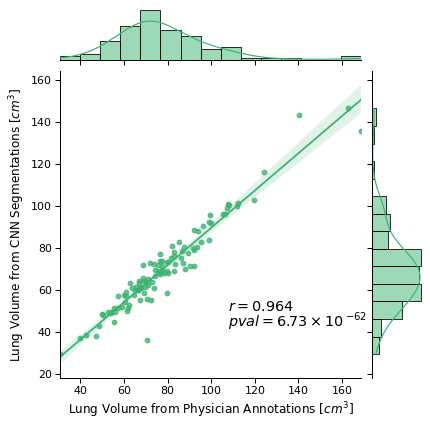

In [30]:
sns.set_context("paper", font_scale=1.25)

x=df_patient['gt_maj_volume'].to_numpy()
y=df_patient['pred_maj_volume'].to_numpy()
r, p = stats.pearsonr(x, y)
r=round(r,4)
print('r=',r,'p=',p)
g=sns.jointplot(data=df_patient, x="gt_maj_volume", y="pred_maj_volume", kind="reg", color="mediumseagreen")
g.set_axis_labels("Lung Volume from Physician Annotations [$cm^3$]","Lung Volume from CNN Segmentations [$cm^3$]",fontsize = 12)

plt.text(-61, 50, r'$r={:.3f}$'.format(r), size='large', color='black')#, weight='semibold')
plt.text(-61, 43, r'$pval=6.73 \times 10^-$'.format(Decimal(p)), size='large', color='black')#, weight='semibold')
plt.text(-8, 46, '$62$'.format(Decimal(p)), size='small', color='black')#, weight='semibold')
#plt.savefig('Corr_Volume.pdf')
plt.show()



In [15]:
df_regression_lufu['functional_res_cap_per_kg']=df_regression_lufu['functional_residual_capacity']*1000/df_regression_lufu['birth_weight_g']
df_regression_lufu['volume_per_kg']=df_regression_lufu['volume']*1000/df_regression_lufu['birth_weight_g']
df_regression_lufu['tidal_volume_per_kg']=df_regression_lufu['tidal_volume_pre']*1000/df_regression_lufu['birth_weight_g']

32
r= 0.6059149096491414 p= 0.0002377097337302164


Text(-3.9, 42, '$4$')

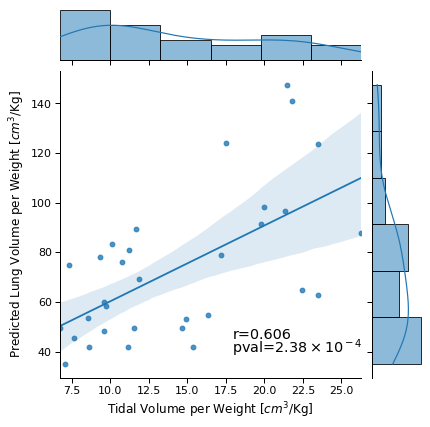

In [16]:
df_lufu_plot = df_regression_lufu.dropna(subset=['tidal_volume_per_kg'])
sns.set_context("paper", font_scale=1.25)

x=df_lufu_plot['tidal_volume_per_kg'].to_numpy()
print(len(x))
y=df_lufu_plot['volume_per_kg'].to_numpy()
r, p = stats.pearsonr(x, y)
print('r=',r,'p=',p)


g=sns.jointplot(data=df_lufu_plot, x="tidal_volume_per_kg", y="volume_per_kg", kind="reg")
g.set_axis_labels("Tidal Volume per Weight [$cm^3$/Kg]","Predicted Lung Volume per Weight [$cm^3$/Kg]")

plt.text(-31, 45, 'r={:.3f}'.format(r), size='large', color='black')#, weight='semibold')
#plt.text(-20, 40, 'pval={:.2E}'.format(Decimal(p)), size='large', color='black')#, weight='semibold')
plt.text(-31, 40, r'pval=$2.38 \times 10^-$'.format(Decimal(p)), size='large', color='black')#, weight='semibold')
plt.text(-3.9, 42, '$4$', size='small', color='black')#, weight='semibold')

#plt.savefig('Tidal_Vol.pdf')

27
r= 0.7030905982053156 p= 4.311961023732353e-05


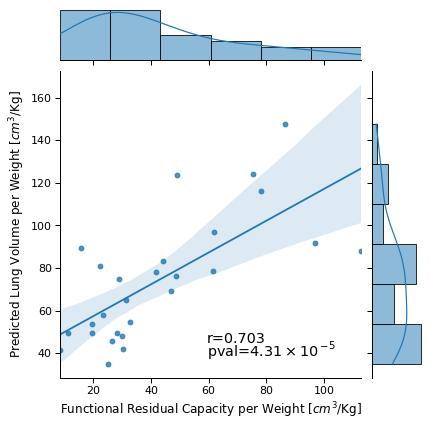

In [17]:
df_lufu_plot_2 = df_regression_lufu.dropna(subset=['functional_residual_capacity'])
sns.set_context("paper", font_scale=1.25)

x=df_lufu_plot_2['functional_res_cap_per_kg'].to_numpy()
print(len(x))
y=df_lufu_plot_2['volume_per_kg'].to_numpy()
r, p = stats.pearsonr(x, y)
print('r=',r,'p=',p)

g=sns.jointplot(data=df_lufu_plot_2, x="functional_res_cap_per_kg", y="volume_per_kg", kind="reg")
g.set_axis_labels("Functional Residual Capacity per Weight [$cm^3$/Kg]","Predicted Lung Volume per Weight [$cm^3$/Kg]")
plt.text(-30, 45, 'r={:.3f}'.format(r), size='large', color='black')#, weight='semibold')
#plt.text(-20, 39, 'pval={:.2E}'.format(Decimal(p)), size='large', color='black')#, weight='semibold')
plt.text(-30, 39, r'pval=$4.31 \times 10^-$'.format(Decimal(p)), size='large', color='black')#, weight='semibold')
plt.text(-8, 42, '$5$', size='small', color='black')#, weight='semibold')


#plt.savefig('FRC.pdf')
plt.show()

## Figure 3 - Lung Volume vs BPD Severity Indicators

In [18]:
# Select variables
selected = [
    'id', 'gender', 'apgar_5min',
    'respiration_inv_days',
    'respiration_non_inv_days',
    'oxygen_demand_days',
    'early_onset_infection', 'steroids', 'bpd_severity',
    'gest_age', 'birth_weight_g','body_size_cm',
    'volume', 'volume_ratio',
]

df_regression=df_regression_lufu[selected]

# Create volume variable but normalized by the birth weight
volume_per_kg= 1000*df_regression['volume'].to_numpy()/df_regression['birth_weight_g'].to_numpy()
df_regression.insert(13, "volume_per_kg", volume_per_kg, True)


In [19]:
### Kruskal Wallis Lung Vol
df_kw = df_regression[['volume_per_kg','bpd_severity']]


df_patient_filter = df_kw.loc[df_kw['bpd_severity'] == 0.0]
bpd_0 = df_patient_filter['volume_per_kg']

df_patient_filter = df_kw.loc[df_kw['bpd_severity'] == 1.0]
bpd_1 = df_patient_filter['volume_per_kg']

df_patient_filter = df_kw.loc[df_kw['bpd_severity'] == 2.0]
bpd_2 = df_patient_filter['volume_per_kg']

df_patient_filter = df_kw.loc[df_kw['bpd_severity'] == 3.0]
bpd_3 = df_patient_filter['volume_per_kg']


k, p = stats.kruskal(bpd_0, bpd_1, bpd_2, bpd_3)
print('k=',k,'p=',p)

k= 43.863369490852676 p= 1.6134820955789063e-09


In [20]:
# Mann–Whitney U test - Wilcoxon–Mann–Whitney test

U01, p01 = mannwhitneyu( bpd_0, bpd_1, alternative='two-sided')
print('0-1', U01, p01)

U02, p02 = mannwhitneyu(bpd_0,  bpd_2, alternative='two-sided')
print('0-2', U02, p02)

U03, p03 = mannwhitneyu(bpd_0, bpd_3, alternative='two-sided')
print('0-3', U03, p03)

U12, p12 = mannwhitneyu(bpd_1,  bpd_2, alternative='two-sided')
print('1-2', U12, p12)

U13, p13 = mannwhitneyu(bpd_1, bpd_3,alternative='two-sided')
print('1-3', U13, p13)

U23, p23 = mannwhitneyu(bpd_2, bpd_3,alternative='two-sided')
print('2-3', U23, p23)

0-1 226.0 2.443754917036578e-06
0-2 25.0 2.3556702328056714e-05
0-3 57.0 5.726777622889317e-07
1-2 98.0 0.0065944823618262335
1-3 210.0 0.004049236740798117
2-3 111.0 0.983530382409258


In [21]:
pvals = [p01, p02, p03, p12, p13]

# Create a list of the Bonferroni adjusted p-values
p_adjusted = multipletests(pvals, alpha=.05, method='bonferroni')
print('p-values Bonferroni correction, (p01,p02,p03,p12,p13)', p_adjusted)

p-values Bonferroni correction, (p01,p02,p03,p12,p13) (array([ True,  True,  True,  True,  True]), array([1.22187746e-05, 1.17783512e-04, 2.86338881e-06, 3.29724118e-02,
       2.02461837e-02]), 0.010206218313011495, 0.01)


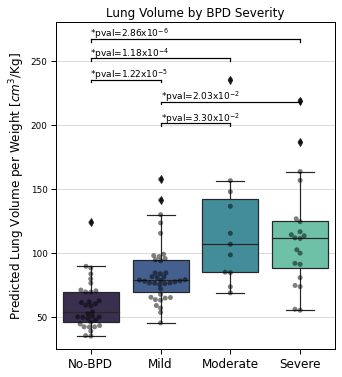

In [22]:
sns.set_context("paper")

df_plot = df_regression[['volume_per_kg','bpd_severity']]

f = plt.figure(figsize=(5, 6))
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0, 0])


sns.boxplot(x='bpd_severity', y='volume_per_kg',
            data=df_plot, 
            palette="mako",
            # width=0.4
           )

sns.swarmplot(x='bpd_severity', y='volume_per_kg',
              data=df_plot,
              color='black',
              alpha=0.5,
              size=5,
              dodge=True
           )

plt.plot([0,3],[267,267], 'k')
plt.plot([0,0],[265,267], 'k')
plt.plot([3,3],[265,267], 'k')
plt.text(-0.01, 269, '*pval=2.86x10$^{-6}$', fontsize=9)

plt.plot([0,2],[252,252], 'k')
plt.plot([0,0],[250,252], 'k')
plt.plot([2,2],[250,252], 'k')
plt.text(-0.01, 254, '*pval=1.18x10$^{-4}$', fontsize=9)

plt.plot([0,1],[235,235], 'k')
plt.plot([0,0],[233,235], 'k')
plt.plot([1,1],[233,235], 'k')
plt.text(-0.01, 237, '*pval=1.22x10$^{-5}$', fontsize=9)

plt.plot([1,3],[218,218], 'k')
plt.plot([1,1],[216,218], 'k')
plt.plot([3,3],[216,218], 'k')
plt.text(1, 220, '*pval=2.03x10$^{-2}$', fontsize=9)

plt.plot([1,2],[201,201], 'k')
plt.plot([1,1],[199,201], 'k')
plt.plot([2,2],[199,201], 'k')
plt.text(1, 203, '*pval=3.30x10$^{-2}$', fontsize=9)


ax.set_title('Lung Volume by BPD Severity', fontsize = 12)
ax.set(xlabel='', ylabel='Predicted Lung Volume per Weight [cm3/Kg]')
ax.set_xlabel('')
ax.set_ylabel('Predicted Lung Volume per Weight [$cm^3$/Kg]', fontsize = 12)

ax.set_xticks(range(4)) # <--- set the ticks first
ax.set_xticklabels(['No-BPD','Mild','Moderate', 'Severe'], fontsize = 12)

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')

ax.set_ylim([25, 280])

#plt.savefig('Volume_by_severity.pdf')
plt.show()

In [23]:
df_plot_data=df_regression_lufu.dropna(subset=['respiration_inv_days', 'respiration_non_inv_days', 'oxygen_demand_days'])
df_plot_data['days_respiratory_support'] = df_plot_data['respiration_inv_days']+df_plot_data['respiration_non_inv_days']

In [24]:
df_plot_data.shape

(103, 32)

r 0.7384212172610066 p 5.542504556958783e-19
r 0.62180411818953 p 2.3889894871316413e-12


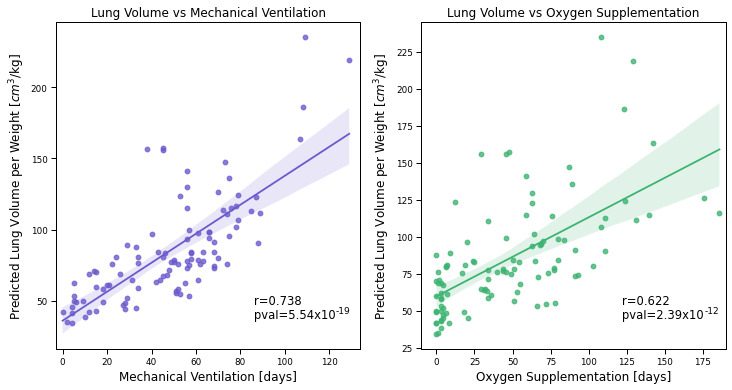

In [25]:
font_s=12
df_BPD_2_3 = df_plot_data


x2=df_BPD_2_3['days_respiratory_support'].to_numpy()
y2=df_BPD_2_3['volume_per_kg'].to_numpy()
r2, p2 = stats.pearsonr(x2, y2)
r2_2=round(r2*r2,4)
print('r',r2,'p',p2)


x=df_BPD_2_3['oxygen_demand_days'].to_numpy()
y=df_BPD_2_3['volume_per_kg'].to_numpy()
r, p = stats.pearsonr(x, y)
r_2=round(r*r,4)
print('r',r,'p',p)


fig, axs = plt.subplots(1,2, figsize=(12,6))

sns.regplot(x="days_respiratory_support", y="volume_per_kg", data=df_BPD_2_3, ax=axs[0], color='slateblue')
axs[0].set_ylabel('Predicted Lung Volume per Weight [$cm^3$/kg]', fontsize = font_s)
axs[0].set_xlabel('Mechanical Ventilation [days]', fontsize = font_s)
axs[0].set_xlim(-3,134)
axs[0].set_title('Lung Volume vs Mechanical Ventilation', fontsize = font_s)

plt.text(-120, 55, 'r={:.3f}'.format(r2), size='large', color='black')#, weight='semibold')
plt.text(-120, 45, 'pval=5.54x10'.format(p), size='large', color='black')#, weight='semibold')
plt.text(-66, 48.5, '-19'.format(p), size='large', color='black', fontsize=9)

sns.regplot(x="oxygen_demand_days", y="volume_per_kg", data=df_BPD_2_3, ax=axs[1], color='mediumseagreen')
axs[1].set_ylabel('Predicted Lung Volume per Weight [$cm^3$/kg]', fontsize = font_s)
axs[1].set_xlabel('Oxygen Supplementation [days]', fontsize = font_s)
axs[1].set_xlim(-10,190)
axs[1].set_title('Lung Volume vs Oxygen Supplementation', fontsize = font_s)

plt.text(122, 55, 'r={:.3f}'.format(r), size='large', color='black')#, weight='semibold')
plt.text(122, 45, 'pval=2.39x10'.format(p), size='large', color='black')#, weight='semibold')
plt.text(176, 48.5, '-12'.format(p), size='large', color='black', fontsize=9)

#plt.savefig('Functional_Exploratory_Analysis.pdf')
plt.show()